# A deep learning model for fake news classification based on the pre-trained transformer model Distilbert (model No.1)

In this file the creating and assessing a deep learning model based on the pre-trained transformer model Distilbert is presented. These parameters were used for this model:
- learning rate 0.001 (training) 0.0001 (fine-tuning);
- maximum sequence length was set to 300;
- training-validation-test split 0.4x0.4x0.2.

### Importing libraries

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import optim
from torchsummary import summary
from torchmetrics.classification import Accuracy
from torchvision.transforms import ToTensor, Lambda
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    RobertaConfig, 
    RobertaForSequenceClassification,
    DistilBertTokenizer,
    DistilBertForMaskedLM,
    DistilBertModel,
    DistilBertForSequenceClassification,
    DistilBertConfig,
    pipeline
)

import pickle
import nltk
from nltk.corpus import stopwords
from tokenizers import trainers, models, Tokenizer, pre_tokenizers

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, \
recall_score, confusion_matrix, make_scorer, classification_report,\
 roc_auc_score, average_precision_score, log_loss

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight


import joblib

import gensim
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

from collections import defaultdict
from collections import Counter
from typing import Any, List, Tuple, Union, Dict

from fake_news_dataset_distilbert import FakeNewsDatasetDistilbert1
import warnings
warnings.filterwarnings("ignore")


<IPython.core.display.Javascript object>

In [6]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

### Importing, tokenizing and splitting the dataset¶

the concatenated dataset with columns for fake and true news articles' text and titles was uploaded as a dataframe.

In [7]:
news = pd.read_csv("news.csv")

<IPython.core.display.Javascript object>

Text and titles were combined into a single text column.

In [8]:
news["title_text"] = news["title"] + " " + news["text"]

<IPython.core.display.Javascript object>

Other columns were droped from the dataset.

In [11]:
X = news.drop(
    ["title", "text", "subject", "date", "Unnamed: 0"],
    axis=1,
)

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.5, random_state=42)

<IPython.core.display.Javascript object>

Train, validation and test datasets were created with the Pytorch Lightning class. The class encoded the data into tensors with the Roberta tokenizer.

In [36]:
train_dataset = FakeNewsDatasetDistilbert1(X_train, labels_available=True)
val_dataset = FakeNewsDatasetDistilbert1(X_val, labels_available=True)
test_dataset = FakeNewsDatasetDistilbert1(X_test, labels_available=True)

<IPython.core.display.Javascript object>

The data was encoded correctly (see below).

In [37]:
len(
    train_dataset,
)

17959

<IPython.core.display.Javascript object>

In [39]:
test_dataset[8]

{'input_ids': tensor([  101,  1456,  3577,  2196,  1185,  2951,  1122,  1110,  3021,  1164,
          2520,   131,   158,   119,   156,   119,  2078, 22751,  1708,  3048,
         15740, 18082,  2249,   113, 11336, 27603,   114,   118,  1109,  1426,
          1951,  1163,  9031,  1115,  1103,  1244,  1311,  1156,  1129,  1501,
          1106,  2520,  1106,  1456,  3577,  1165,  1103,  1159,  1110,  1268,
          1133,  1115,  1122,  1180,  1136,  3333,  1208,  1272,   153, 15136,
          4873,  4993,  1144,  2602,  1185,  2951,  1104,   170, 21623,  1106,
          9700,  1157,  8233,  1105,  4272,  5193,   119,  2711,   158,   119,
           156,   119,  2909,  1104,  1426, 10896, 22430, 18608,   188,  2906,
          1113,  9667,  1106,  1838,  7430,  1114,  1456,  3577,  1443,  3073,
           118,  2975,   117,  1426,  1951,  2910,  1116,  9462,  9644, 11896,
         10232,  1204,  1163,  1175,  1156,  1148,  1138,  1106,  1129,   170,
          1669,  1104,  5017,  1107,  1

<IPython.core.display.Javascript object>

The class as a Pytortch Lightning model was created which uses the pretrained Ditilbert model.

### Creating the model class and instantiating the model

In [15]:
lr = 0.001

<IPython.core.display.Javascript object>

In [16]:
class FakeNewsModelDistilbert(pl.LightningModule):
    def __init__(self, num_classes: int = 2, lr: float = lr):
        super().__init__()
        config = DistilBertConfig(
            num_labels=num_classes,
            lr = lr
        )
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-cased", config=config, ignore_mismatched_sizes=True
        )
        self.distilbert_grad(False)
        self.lr = lr
        self.train_losses = []
        self.val_losses = []
    
    def distilbert_grad(self, requires_grad: bool):
        """
        Freezes or unfreezes the parameters of the base DistilBERT model for fine-tuning.
        """
        for param in self.distilbert.base_model.parameters():
            param.requires_grad = requires_grad
    
    def forward(self, input_ids, attention_mask, labels=None):
        if labels is not None:
            outputs = self.distilbert(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )
            loss, logits = outputs.loss, outputs.logits
            return loss, logits
        else:
            logits = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
            return logits
    

    def configure_optimizers(self):
        """
        Configures the optimizer for training the model.

        Returns:
            optimizer (optim.AdamW): AdamW optimizer with specified learning rate and epsilon.
        """
        return optim.AdamW(
            [p for p in self.parameters() if p.requires_grad], lr=self.lr, eps=1e-08
        )

    def train_dataloader(self):
        """
        Returns a DataLoader for the training dataset.

        Returns:
            loader (DataLoader): DataLoader for the training dataset.
        """
        dataset = FakeNewsDatasetDistilbert(X_train)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=3)
        return loader

    def val_dataloader(self):
        """
        Returns a DataLoader for the validation dataset.

        Returns:
            loader (DataLoader): DataLoader for the validation dataset.
        """
        dataset = FakeNewsDatasetDistilbert(X_val)
        loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False, num_workers=3
        )
        return loader

    def test_dataloader(self):
        """
        Returns a DataLoader for the test dataset.

        Returns:
            loader (DataLoader): DataLoader for the test dataset.
        """
        dataset = FakeNewsDatasetDistilbert(X_test)
        loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False, num_workers=3
        )
        return loader

    def training_step(self, batch, batch_idx):
        """
        Performs a single training step.

        Args:
            batch (torch.Tensor): Batch of data.
            batch_idx (int): Index of the batch.

        Returns:
            Loss (torch.Tensor): Loss value.
        """
        bert_input = batch
        loss, logits = self(**bert_input)
        loss = loss.mean()
        self.log("train_loss", loss)
        self.train_losses.append(loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        """
        Performs a single validation step.

        Args:
            val_batch (torch.Tensor): Batch of data.
            batch_idx (int): Index of the batch.

        Returns:
            loss (torch.Tensor): Loss value.
        """
        bert_input = val_batch
        loss, logits = self(**bert_input)
        loss = loss.mean()
        self.log("val_loss", loss)
        self.val_losses.append(loss)
        return loss

    def test_step(self, test_batch, batch_idx):
        """
        Performs a single testing step.

        Args:
            test_batch (torch.Tensor): Batch of data.
            batch_idx (int): Index of the batch.

        Returns:
            logits (torch.Tensor): Logits output from the model.
        """
        bert_input = test_batch
        logits = self(**bert_input)
        return logits

    def test_epoch_end(self, outputs):
        """
        Performs operations on the outputs of the test data.

        Args:
            outputs (list): List of outputs from the test data.

        Returns:
            all_logits (torch.Tensor): Concatenated logits from all batches.
        """
        all_logits = torch.cat(outputs, dim=0)
        return all_logits

    def on_train_epoch_end(self):
        """
        Performs operations at the end of each training epoch.
        """
        train_loss = torch.stack(self.train_losses).mean()
        self.log("avg_train_loss", train_loss)

    def on_validation_epoch_end(self):
        """
        Performs operations at the end of each validation epoch.
        """
        val_loss = torch.stack(self.val_losses).mean()
        self.log("ag_val_loss", val_loss)

<IPython.core.display.Javascript object>

Batch size 5 was used for loading the data. Model was initalized, GPU processor was attached. 

In [17]:
batch_size = 5

<IPython.core.display.Javascript object>

In [18]:
model = FakeNewsModelDistilbert()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized because the shapes did not match:
- distilbert.embeddings.word_embeddings.weight: found shape torch.Size([28996, 768]) in the checkpoint and torch.Size([30522, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [19]:
device = torch.device("mps")


<IPython.core.display.Javascript object>

In [20]:
model.to(device)

FakeNewsModelDistilbert(
  (distilbert): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

<IPython.core.display.Javascript object>

In [21]:
tensorboard_logger = pl.loggers.TensorBoardLogger(
    save_dir="./logs", name="single_label_classification"
)

<IPython.core.display.Javascript object>

### Specifying callbacks

The callback classes were created and callbacks initialized. 

In [22]:
early_stopping_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')


<IPython.core.display.Javascript object>

In [23]:

checkpoint_callback = ModelCheckpoint(
        dirpath="models/",
        filename=f'{{epoch}}-{{val_loss:.2f}}',
        monitor="val_loss",
        save_top_k=3,
        mode="min",
        every_n_epochs=1,
    )


<IPython.core.display.Javascript object>

In [24]:
class ValidationLogCollectorCallback(pl.Callback):
    """
    A PyTorch Lightning callback that collects validation metrics at the end of each validation epoch.
    """

    def __init__(self):
        """
        Initializes the ValidationLogCollectorCallback.
        """
        super().__init__()
        self.validation_metrics = []

    def on_validation_epoch_end(
        self, trainer: pl.Trainer, pl_module: pl.LightningModule
    ):
        """
        Collects the validation metrics at the end of each validation epoch.

        Args:
            trainer (pl.Trainer): The PyTorch Lightning trainer object.
            pl_module (pl.LightningModule): The PyTorch Lightning module being trained.
        """
        metrics = trainer.callback_metrics
        self.validation_metrics.append(metrics)

    def get_metrics_dataframe(self) -> pd.DataFrame:
        """
        Returns a Pandas DataFrame containing the collected validation metrics.

        Returns:
            pd.DataFrame: A Pandas DataFrame containing the collected validation metrics.
        """
        return pd.DataFrame(self.validation_metrics)

<IPython.core.display.Javascript object>

In [25]:
class EpochTimeCallback(pl.Callback):
    """
    A PyTorch Lightning callback to measure and store the duration of each epoch.
    
    Attributes:
    epoch_times_df (pd.DataFrame): A dataframe containing epoch numbers and their corresponding durations.
    """

    def __init__(self):
        """Initializes the callback and sets up an empty dataframe to store epoch times."""
        super().__init__()
        self.epoch_times_df: pd.DataFrame = pd.DataFrame(columns=['Epoch', 'Duration'])

    def on_epoch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """
        Record the start time of the epoch.

        Args:
        trainer (pl.Trainer): The trainer object.
        pl_module (pl.LightningModule): The model/module being trained.
        """
        self.epoch_start_time = time.time()

    def on_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """
        Calculate and store the duration of the epoch, and print the epoch duration.

        Args:
        trainer (pl.Trainer): The trainer object.
        pl_module (pl.LightningModule): The model/module being trained.
        """
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        epoch = trainer.current_epoch + 1

        self.epoch_times_df.loc[len(self.epoch_times_df)] = [epoch, epoch_duration]
        print(f"Epoch {epoch} execution time: {epoch_duration:.2f} seconds")

    def get_epoch_times_df(self) -> pd.DataFrame:
        """
        Retrieve the dataframe containing epoch durations.

        Returns:
        pd.DataFrame: A dataframe containing epoch numbers and their corresponding durations.
        """
        return self.epoch_times_df


<IPython.core.display.Javascript object>

In [26]:
log_collector = ValidationLogCollectorCallback()

<IPython.core.display.Javascript object>

In [27]:
epoch_time_callback = EpochTimeCallback()

<IPython.core.display.Javascript object>

### Training the model

The metrics of each models as well as time used for training and prediction were recorded into a dictionary which will be later transformed into a pandas dataframe in order to compare scores of various models. Initially, the structure of the dictionary was set that was latter filled with the appended data from the steps of training, model assessment and predictions. 

In [28]:
metrics_df = {}
metrics_df["model_name"] = []
metrics_df["train_time"] = []
metrics_df["tune_time"] = []
metrics_df["prediction_time_trained"] = []
metrics_df["prediction_time_tuned"] = []
metrics_df["train_loss_trained"] = []
metrics_df["train_loss_tuned"] = []
metrics_df["val_loss_trained"] = []
metrics_df["val_loss_tuned"] = []

<IPython.core.display.Javascript object>

The model is trained with the Pytorch Lighntning trainer and, after the training process ended, is got saved into a local file. Data on the total training time is saved in the dictionary. 

In [24]:

start_time = time.time()
trainer = pl.Trainer(
    max_epochs=10,
    logger=tensorboard_logger,
    callbacks=[
        checkpoint_callback,
        log_collector,
        early_stopping_callback,
        epoch_time_callback,
    ],
)
trainer.fit(
    model
    #ckpt_path=last_checkpoint_path
)
#trainer_list.append(trainer)
end_time = time.time()
exec_time = (end_time - start_time) / len(train_dataset)
print("")
print(f"Model_name: Distilbert")
print(f"Execution time: {exec_time}")
metrics_df["model_name"].append("Distilbert")
metrics_df["train_time"].append(exec_time)
checkpoint_path = f"models/model_trained_Distilbert2.ckpt"
trainer.save_checkpoint(checkpoint_path)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type                                | Params
-------------------------------------------------------------------
0 | distilbert | DistilBertForSequenceClassification | 67.0 M
-------------------------------------------------------------------
592 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Model_name: Distilbert
Execution time: 0.44870544300358667


<IPython.core.display.Javascript object>

The training of the models with many layers freezed was conducted for maximum ten epochs, however, it was interupted by early stopping callback after 4 epochs. 

### Fine-tuning the model

The next step is to fine-tune the model - that is, to calculate gradients by comparing predicted outputs with label data and adjust weights accordingly. 

First, the trained model is loaded from the local checkpoint path.

Bert_grad parameter is set to True in order to allow calculation os gradients.

In [25]:
last_checkpoint_path = f"models/model_trained_Distilbert2.ckpt"

model = FakeNewsModelDistilbert.load_from_checkpoint(
    checkpoint_path=last_checkpoint_path,
    batch_size=batch_size,
    num_classes=2,
    model="Distilbert",
    lr=0.0001,
)

device = torch.device("mps")
model.to(device)

model.distilbert_grad(True)

start_time = time.time()
trainer = pl.Trainer(
    max_epochs=30,
    logger=tensorboard_logger,
    callbacks=[
        checkpoint_callback,
        log_collector,
        early_stopping_callback,
        epoch_time_callback,
    ],
)
trainer.fit(
    model,
    DataLoader(train_dataset, batch_size),
    # ckpt_path=last_checkpoint_path
)
end_time = time.time()
exec_time = (end_time - start_time) / len(train_dataset)
print("")
print(f"Model_name: Distilbert")
print(f"Execution time: {exec_time}")
metrics_df["tune_time"].append(exec_time)
checkpoint_path = f"models/model_tuned_Distilbert.ckpt"
trainer.save_checkpoint(checkpoint_path)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized because the shapes did not match:
- distilbert.embeddings.word_embeddings.weight: found shape torch.Size([28996, 768]) in the checkpoint and torch.Size([30522, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type                       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Model_name: Distilbert
Execution time: 0.5045651809244832


<IPython.core.display.Javascript object>

The fine-tuning of the model stopped after 3 epochs (though maximum 30 epochs were set). 

### Predictions on the trained model and validation and test datasets

Next, predictions on the fine-tuned model were generated. The model was loaded from the checkpoint path.

In [29]:
checkpoint_path = f"models/model_trained_Distilbert2.ckpt"
model = FakeNewsModelDistilbert.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    batch_size=batch_size,
    num_classes=2,
    model="Distilbert",
    lr=0.001,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized because the shapes did not match:
- distilbert.embeddings.word_embeddings.weight: found shape torch.Size([28996, 768]) in the checkpoint and torch.Size([30522, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

The GPU processor is attached to models, sample weights, and to the eval() function. 

In [30]:
device = torch.device("mps")
model.to(device)
model = model.eval().to(device)


<IPython.core.display.Javascript object>

For the prediction, data is loaded from the validation dataset with the validation loader.

In [42]:
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=3
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=3
)

<IPython.core.display.Javascript object>

#### Validation dataset

Predictions are generated on the trained model and the fine-tuned model and saved into the list. Trues values are also set to a list as well as losses.

In [62]:
y_val_pred_trained = []
y_true_trained = []
losses_trained = []
sigmoids_list_trained = []
start_time = time.time()
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss, outputs = model(**batch)
        sigmoids = torch.sigmoid(outputs)
        preds = (sigmoids > 0.5).to(torch.int)
        y_val_pred_trained += preds.tolist()
        y_true_trained += batch["labels"].tolist()
        sigmoids_list_trained.append(sigmoids)
        losses_trained.append(loss.item())
end_time = time.time()
exec_time = (end_time - start_time) / len(val_dataset)

print(f"Prediction time: {exec_time}")


Prediction time: 0.021700182087975414


<IPython.core.display.Javascript object>

The mean of losses of from all prediction values is calculated.

In [63]:
val_loss_trained = np.mean(losses_trained)
metrics_df["val_loss_trained"].append(val_loss_trained)
print("Mean validation loss for the trained model:", val_loss_trained)


Mean validation loss for the trained model: 0.6058896740935826


<IPython.core.display.Javascript object>

#### Test dataset

In [43]:
y_test_pred_trained = []
y_true_trained_test = []
losses_trained_test = []
sigmoids_list_trained_test = []
start_time = time.time()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss, outputs = model(**batch)
        sigmoids = torch.sigmoid(outputs)
        preds = (sigmoids > 0.5).to(torch.int)
        y_test_pred_trained += preds.tolist()
        y_true_trained_test += batch["labels"].tolist()
        sigmoids_list_trained_test.append(sigmoids)
        losses_trained_test.append(loss.item())
end_time = time.time()
exec_time = (end_time - start_time) / len(test_dataset)

print(f"Prediction time: {exec_time}")


Prediction time: 0.021973901522451624


<IPython.core.display.Javascript object>

In [45]:
test_loss_trained = np.mean(losses_trained_test)
print("Mean test loss for the tuned model:", test_loss_trained)

Mean test loss for the tuned model: 0.6062753168339188


<IPython.core.display.Javascript object>

### Predictions on the fine-tuned model and validation and test datasets

Next, predictions on the fine-tuned model were generated. The model was loaded from the checkpoint path.

In [46]:
checkpoint_path = f"models/model_tuned_Distilbert.ckpt"
model2 = FakeNewsModelDistilbert.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    batch_size=batch_size,
    num_classes=2,
    model="Distilbert",
    lr=0.0001,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized because the shapes did not match:
- distilbert.embeddings.word_embeddings.weight: found shape torch.Size([28996, 768]) in the checkpoint and torch.Size([30522, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

The GPU processor is attached to models, sample weights, and to the eval() function. 

In [47]:
device = torch.device("mps")
model2.to(device)
model2 = model2.eval().to(device)


<IPython.core.display.Javascript object>

For the prediction, data is loaded from the validation dataset with the validation loader.

In [48]:
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=3
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=3
)

<IPython.core.display.Javascript object>

#### Validation dataset

Predictions are generated on the trained model and the fine-tuned model and saved into the list. Trues values are also set to a list as well as losses.

In [49]:
y_val_pred_tuned = []
y_true_tuned = []
losses_tuned = []
sigmoids_list_tuned = []
start_time = time.time()
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss, outputs = model2(**batch)
        sigmoids = torch.sigmoid(outputs)
        preds = (sigmoids > 0.5).to(torch.int)
        y_val_pred_tuned += preds.tolist()
        y_true_tuned += batch["labels"].tolist()
        sigmoids_list_tuned.append(sigmoids)
        losses_tuned.append(loss.item())
end_time = time.time()
exec_time = (end_time - start_time) / len(val_dataset)

print(f"Prediction time: {exec_time}")


Prediction time: 0.02203211390605064


<IPython.core.display.Javascript object>

The mean of losses of from all prediction values is calculated.

In [50]:
val_loss_tuned = np.mean(losses_tuned)
metrics_df["val_loss_tuned"].append(val_loss_tuned)
print("Mean validation loss for the tuned model:", val_loss_tuned)


Mean validation loss for the tuned model: 0.03285893765925056


<IPython.core.display.Javascript object>

#### Test dataset

In [51]:
y_test_pred_tuned = []
y_true_tuned_test = []
losses_tuned_test = []
sigmoids_list_tuned_test = []
start_time = time.time()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss, outputs = model2(**batch)
        sigmoids = torch.sigmoid(outputs)
        preds = (sigmoids > 0.5).to(torch.int)
        y_test_pred_tuned += preds.tolist()
        y_true_tuned_test += batch["labels"].tolist()
        sigmoids_list_tuned_test.append(sigmoids)
        losses_tuned_test.append(loss.item())
end_time = time.time()
exec_time = (end_time - start_time) / len(test_dataset)

print(f"Prediction time: {exec_time}")

Prediction time: 0.025482823508884964


<IPython.core.display.Javascript object>

In [52]:
test_loss_tuned = np.mean(losses_tuned_test)
print("Mean test loss for the tuned model:", test_loss_tuned)

Mean test loss for the tuned model: 0.025447170999816894


<IPython.core.display.Javascript object>

The dictionary with the added validation and test metrics was saved to the local file.

In [53]:
with open("metrics_df.pkl", "wb") as fp:
    pickle.dump(metrics_df, fp)
    print("The dictionary saved to a file.")

The dictionary saved to a file.


<IPython.core.display.Javascript object>

## Assessments of trained and fine-tuned models

### Confusion matrix

Based on values which were generated from running the models on validation data, confusion matrixes are created and presented as heatmaps bellow. 

In [74]:
y_val_pred_trained2 = [sublist[1] for sublist in y_val_pred_trained]
y_test_pred_trained2 = [sublist[1] for sublist in y_test_pred_trained]

y_val_pred_tuned2 = [sublist[1] for sublist in y_val_pred_tuned]
y_test_pred_tuned2 = [sublist[1] for sublist in y_test_pred_tuned]

<IPython.core.display.Javascript object>

In [75]:
conf_mat_trained = confusion_matrix(y_true_trained, y_val_pred_trained2)
conf_mat_trained_test = confusion_matrix(y_true_trained_test, y_test_pred_trained2)

conf_mat_tuned = confusion_matrix(y_true_tuned, y_val_pred_tuned2)
conf_mat_tuned_test = confusion_matrix(y_true_tuned_test, y_test_pred_tuned2)

<IPython.core.display.Javascript object>

#### Assessments of the trained model

##### Validation dataset

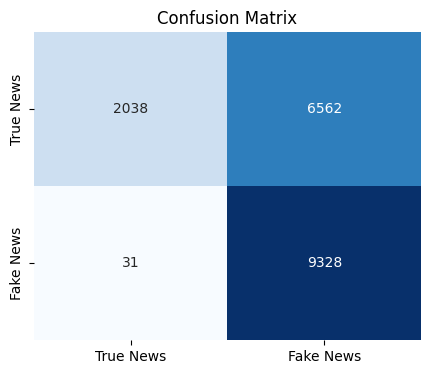

<IPython.core.display.Javascript object>

In [66]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat_trained, annot=True, fmt="d", cmap="Blues", cbar=False)
classes = ["True News", "Fake News"]
plt.xticks(ticks=np.arange(2) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(2) + 0.5, labels=classes)
plt.title("Confusion Matrix")
plt.show()

##### Test dataset

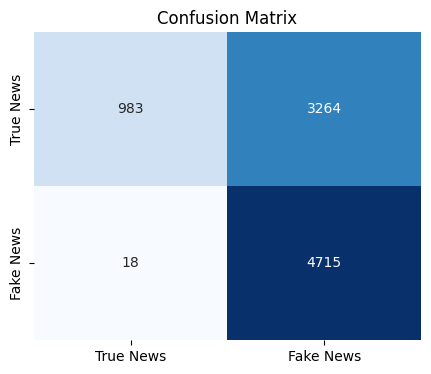

<IPython.core.display.Javascript object>

In [67]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat_trained_test, annot=True, fmt="d", cmap="Blues", cbar=False)
classes = ["True News", "Fake News"]
plt.xticks(ticks=np.arange(2) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(2) + 0.5, labels=classes)
plt.title("Confusion Matrix")
plt.show()

#### Assessments of the fine-tuned model

##### Validation dataset

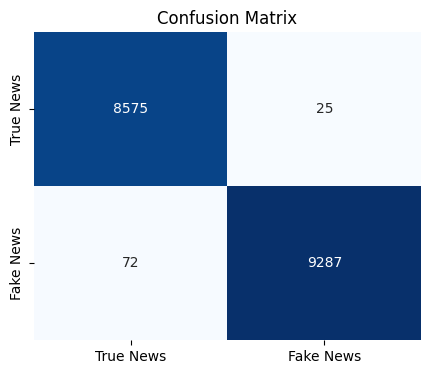

<IPython.core.display.Javascript object>

In [68]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat_tuned, annot=True, fmt="d", cmap="Blues", cbar=False)
classes = ["True News", "Fake News"]
plt.xticks(ticks=np.arange(2) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(2) + 0.5, labels=classes)
plt.title("Confusion Matrix")
plt.show()

##### Test dataset

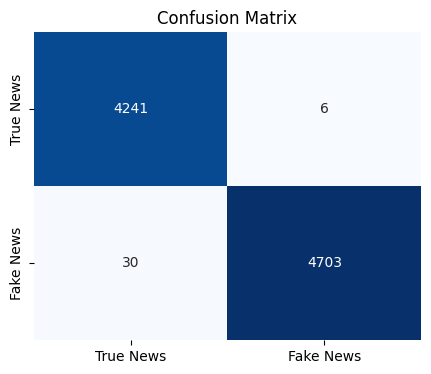

<IPython.core.display.Javascript object>

In [69]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat_tuned_test, annot=True, fmt="d", cmap="Blues", cbar=False)
classes = ["True News", "Fake News"]
plt.xticks(ticks=np.arange(2) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(2) + 0.5, labels=classes)
plt.title("Confusion Matrix")
plt.show()

### Classification reports

In [73]:
class_names = ["True News", "Fake News"]
print("Assessments of the trained model:")
print('')
print("Validation dataset:")
classification_report_trained = classification_report(y_true_trained, y_val_pred_trained2, target_names=class_names)
print(classification_report_trained)
print("Test dataset:")
classification_report_trained_test = classification_report(y_true_trained_test, y_test_pred_trained2, target_names=class_names)
print(classification_report_trained_test)
print('')
print("Assessments of the fine-tuned model:")
print('')
print("Validation dataset:")
classification_report_tuned = classification_report(y_true_tuned, y_val_pred_tuned2, target_names=class_names)
print(classification_report_tuned)
print("Test dataset:")
classification_report_tuned_test = classification_report(y_true_tuned_test, y_test_pred_tuned2, target_names=class_names)
print(classification_report_tuned_test)

Assessments of the trained model:

Validation dataset:
              precision    recall  f1-score   support

   True News       0.99      0.24      0.38      8600
   Fake News       0.59      1.00      0.74      9359

    accuracy                           0.63     17959
   macro avg       0.79      0.62      0.56     17959
weighted avg       0.78      0.63      0.57     17959

Test dataset:
              precision    recall  f1-score   support

   True News       0.98      0.23      0.37      4247
   Fake News       0.59      1.00      0.74      4733

    accuracy                           0.63      8980
   macro avg       0.79      0.61      0.56      8980
weighted avg       0.78      0.63      0.57      8980


Assessments of the fine-tuned model:

Validation dataset:
              precision    recall  f1-score   support

   True News       0.99      1.00      0.99      8600
   Fake News       1.00      0.99      0.99      9359

    accuracy                           0.99     17959


<IPython.core.display.Javascript object>

### Conclusions for this part

It can be observed that:
- the trained model performed not well both with validation and test datasets;
- the fine-tuned model performed quite well both with validation and test dataset (f1 score equal to 0.99 for validation and 1 for test dataset).